accuracy verification with new data

In [1]:
import pandas as pd
import itertools
import datetime

import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace.sarimax import SARIMAX

import ml_metrics as metrics
import warnings
warnings.filterwarnings("ignore")

# Old Data

In [2]:
def dateparse(time):
    return datetime.datetime.fromtimestamp(float(time)/1000)
dataset = pd.read_csv('data/1hBTCUSDT_part_1.csv', parse_dates=['Start', 'Stop'], date_parser=dateparse)

dataset.tail()


,Start,Stop,Open,Close,Low,High,Volume
29471,2020-12-31 22:00:00,2020-12-31 22:59:59.999,28897.84,29126.70,28862.00,29139.65,1936.480299
29472,2020-12-31 23:00:00,2020-12-31 23:59:59.999,29126.71,28966.36,28900.79,29169.55,2524.473111
29473,2021-01-01 00:00:00,2021-01-01 00:59:59.999,28966.36,29100.84,28910.19,29143.73,1438.506326
29474,2021-01-01 01:00:00,2021-01-01 01:59:59.999,29100.83,28923.63,28780.00,29110.35,1976.419299
29475,2021-01-01 02:00:00,2021-01-01 02:59:59.999,28923.63,28995.13,28690.17,29031.34,2311.811445


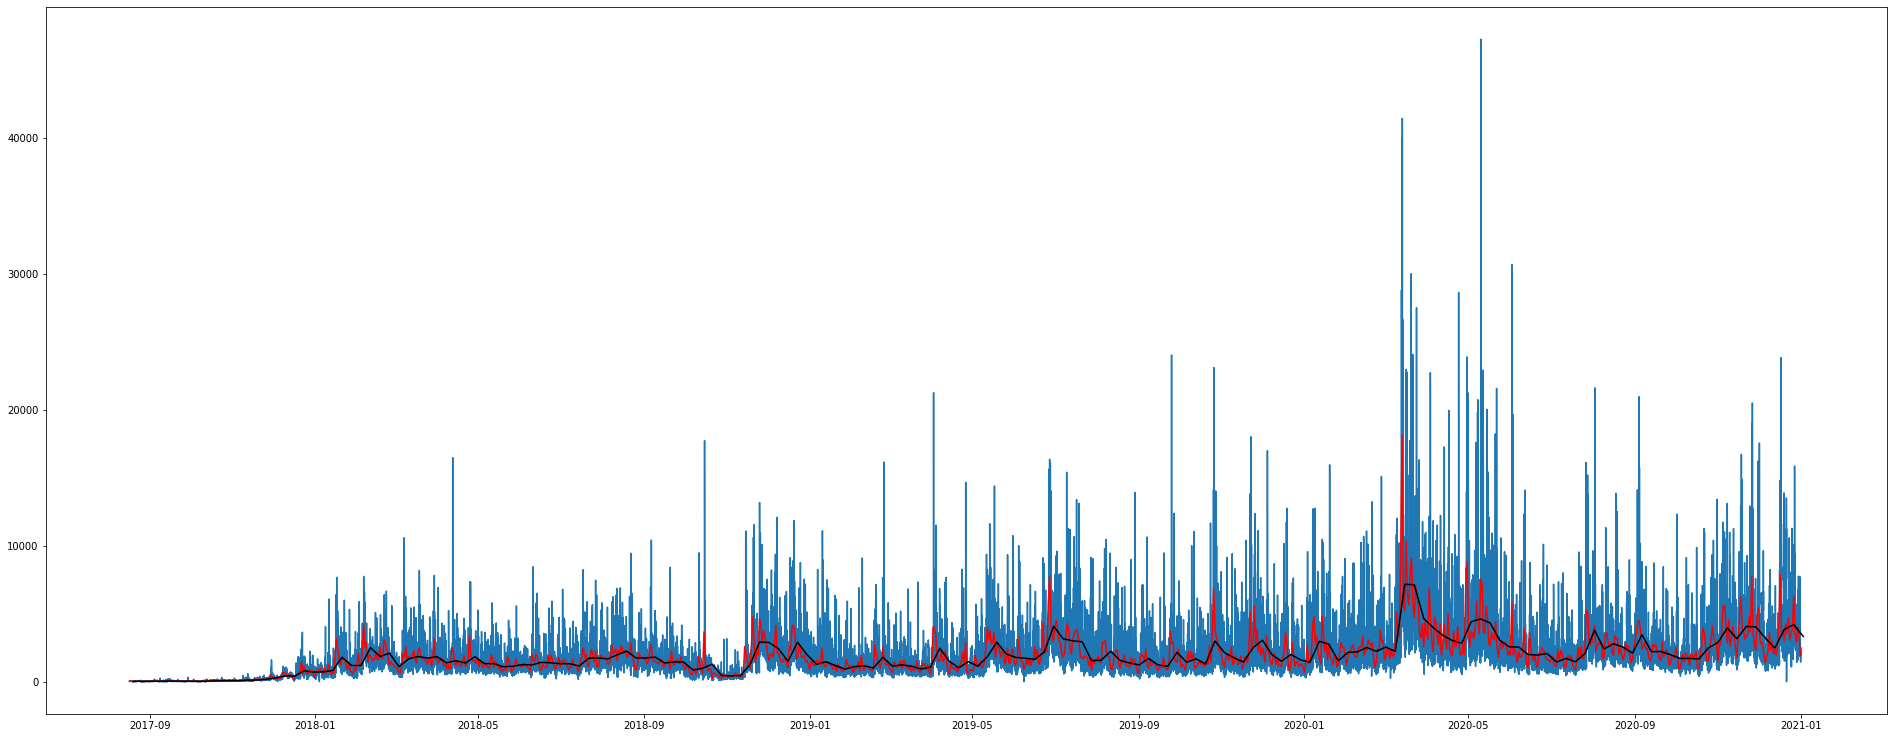

In [3]:
dataset_copy = dataset.copy()
dataset_copy = dataset_copy.set_index('Stop')
y_D = dataset_copy.Volume.resample('D').mean()
y_W = dataset_copy.Volume.resample('W').mean()
plt.figure(figsize=(33, 13))
plt.plot(dataset_copy.Volume)
plt.plot(y_D, 'red')
plt.plot(y_W, 'black')

# New Data

In [4]:
def dateparse(time):
    return datetime.datetime.fromtimestamp(float(time)/1000)
dataset_new = pd.read_csv('data/2021-1h-BTCUSDT_part_2.csv', parse_dates=['Start', 'Stop'], date_parser=dateparse)
dataset_new.index = range(29476, len(dataset_new.Start)+29476)
dataset_new.head()

,Start,Stop,Open,Close,Low,High,Volume
29476,2021-01-01 02:00:00,2021-01-01 02:59:59.999,28923.63,28995.13,28690.17,29031.34,2311.811445
29477,2021-01-01 03:00:00,2021-01-01 03:59:59.999,28995.13,29409.99,28960.35,29470.00,5403.068471
29478,2021-01-01 04:00:00,2021-01-01 04:59:59.999,29410.00,29194.65,29120.03,29465.26,2384.231560
29479,2021-01-01 05:00:00,2021-01-01 05:59:59.999,29195.25,29278.40,29150.02,29367.00,1461.345077
29480,2021-01-01 06:00:00,2021-01-01 06:59:59.999,29278.41,29220.31,29029.40,29395.00,2038.046803


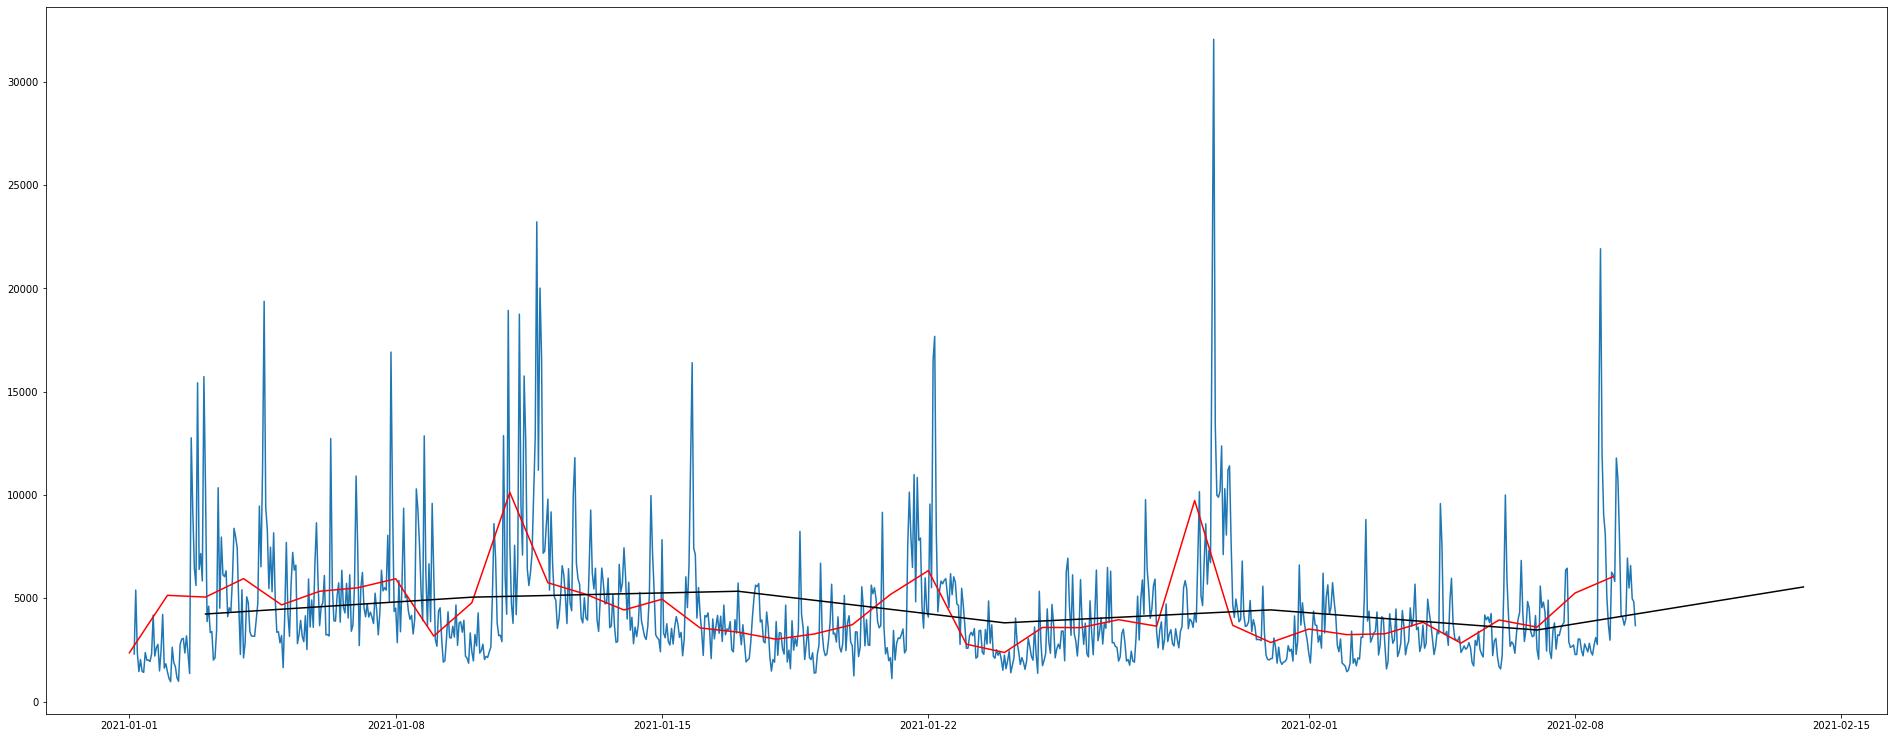

In [5]:
dataset_new_copy = dataset_new.copy()
dataset_new_copy = dataset_new_copy.set_index('Stop')
y_new_D = dataset_new_copy.Volume.resample('D').mean()
y_new_W = dataset_new_copy.Volume.resample('W').mean()
plt.figure(figsize=(33, 13))
plt.plot(dataset_new_copy.Volume)
plt.plot(y_new_D, 'red')
plt.plot(y_new_W, 'black')

# Сomparison of the best models from previous studies 

## Autoregression (AR)

In [6]:
model = AutoReg(dataset.Volume, lags=25, old_names=False)
model_fit = model.fit()
yhat1 = model_fit.predict(len(dataset.Volume), len(dataset.Volume)+29)

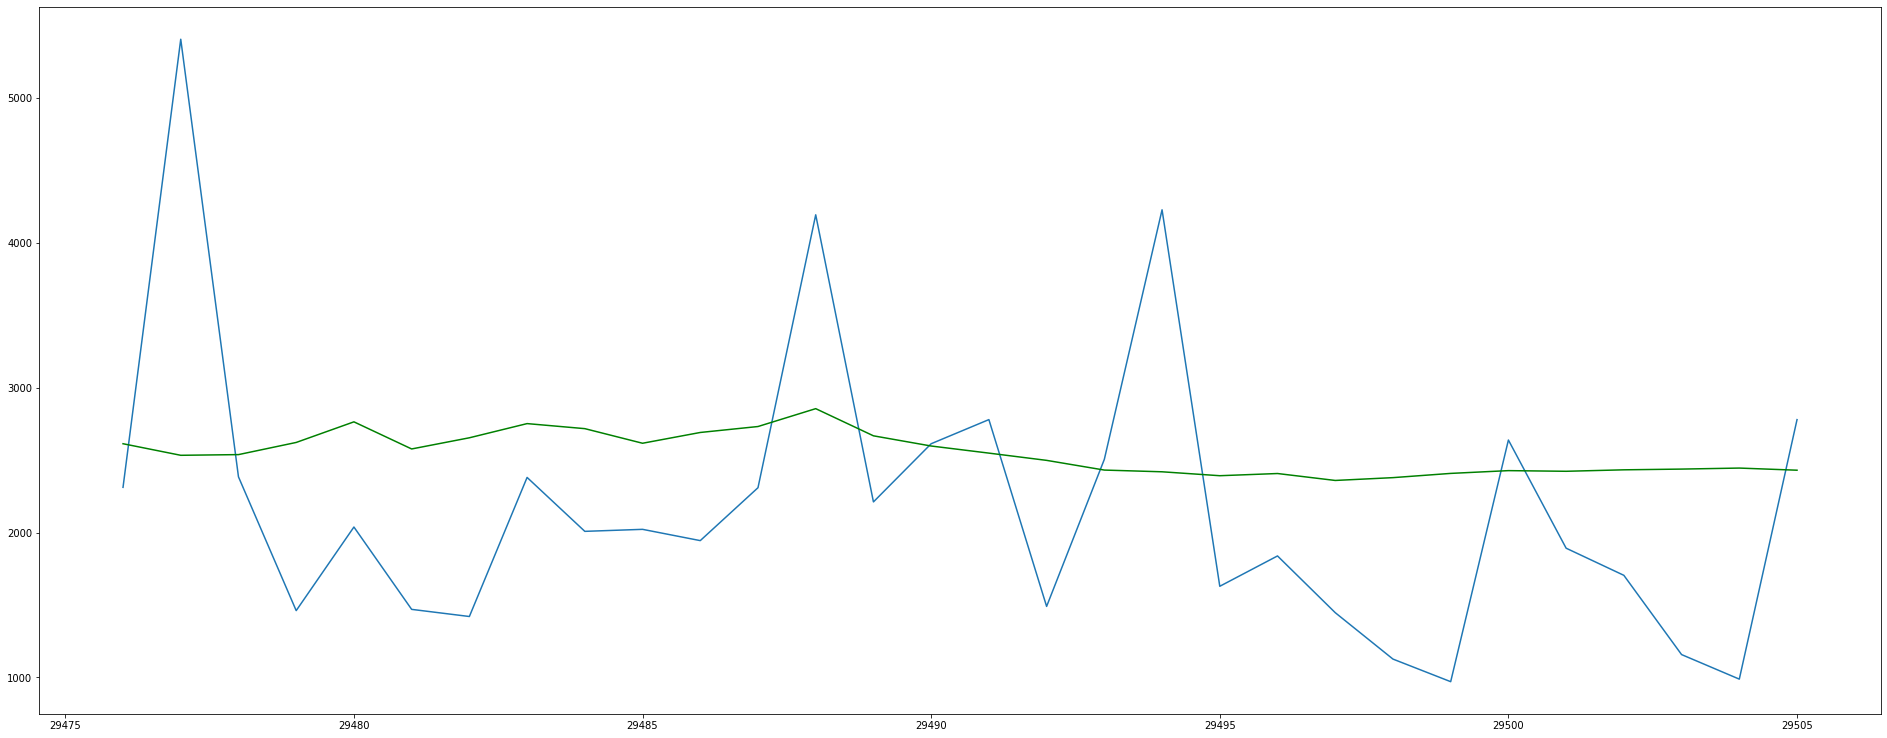

In [7]:
plt.figure(figsize=(33, 13))
plt.plot(dataset_new.Volume[:30])
plt.plot(yhat1, 'green')

In [8]:
print(int(metrics.mae(dataset_new.Volume[:30], yhat1)), '- mean absolute error')

826 - mean absolute error


## Seasonal Autoregressive Integrated Moving-Average (SARIMA)

search parameters

In [9]:
P = D = Q = range(0, 2)
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(P, D, Q))]

In [10]:
def search_param(seasonal_pdq, best_aic = float("inf"), best_param_seasonal = None):
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(y_W,
                          order=(2, 0, 8),
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)
            results = mod.fit()
            aic =  results.aic
            if aic < best_aic:
                best_aic = aic
                best_param_seasonal = param_seasonal

            # print('ARIMA{}x{}52 - AIC:{}'.format((2, 0, 8), param_seasonal, aic))
        except:
            continue
    # print(best_aic, (2, 0, 8), best_param_seasonal)            
    return best_aic, (2, 0, 8), best_param_seasonal

process call 

In [11]:
best_aic, best_param, best_param_seasonal = search_param(seasonal_pdq)

In [12]:
model = SARIMAX(y_D, order=best_param, seasonal_order=best_param_seasonal)
model_fit = model.fit()

drawing graphs

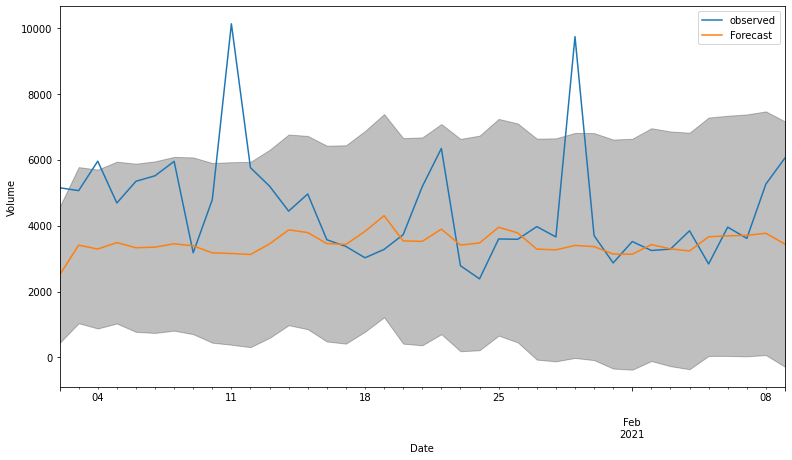

In [13]:
pred_uc = model_fit.get_forecast(steps=39)
pred_ci = pred_uc.conf_int()
ax = y_new_D[1:].plot(label='observed', figsize=(13, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Volume')
plt.legend()
plt.show()

In [14]:
yhat2 =  model_fit.predict(len(y_D), len(y_D)+38)
print(int(metrics.mae(y_new_D[1:], yhat2)), '- mean absolute error')

1355 - mean absolute error
